### Modern CNN with TF-slim

In [1]:
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")


CURRENT TF VERSION IS [1.12.0]
PACKAGES LOADED


### Load MNIST dataset

In [2]:
mnist = keras.datasets.mnist
(trainimg, trainlabel), (testimg, testlabel) = mnist.load_data()

# Img size : 28 x 28 x 1
# Num classes : 10

### Data exploration

In [3]:
print('Training data shape : ', trainimg.shape)
print('Class dataset : ', trainlabel.shape)
print('Testing data shape : ', testimg.shape)
print('Class dataset : ', testlabel.shape)

Training data shape :  (60000, 28, 28)
Class dataset :  (60000,)
Testing data shape :  (10000, 28, 28)
Class dataset :  (10000,)


### Data preprocessing

In [4]:
N_TRN = len(trainlabel)
N_TST = len(testlabel)

onehot_mat = np.eye(10)

trainimg  = np.reshape(trainimg, [-1, 784])
testimg   = np.reshape(testimg, [-1, 784])

trainlabel = np.concatenate([[onehot_mat[int(x),:]] for x in trainlabel], axis=0)
testlabel   = np.concatenate([[onehot_mat[int(x),:]] for x in testlabel], axis=0)

print('Training data shape : ', trainimg.shape)
print('Class dataset : ', trainlabel.shape)
print('Testing data shape : ', testimg.shape)
print('Class dataset : ', testlabel.shape)
# train_images_flat = sess.run(tf.reshape(train_images, shape=(N_TRN,-1)))
# test_images_flat  = sess.run(tf.reshape(test_images, shape=(N_TST,-1)))
# train_labels_1h   = sess.run(tf.one_hot(train_labels, depth=n_classes))
# test_labels_1h    = sess.run(tf.one_hot(test_labels, depth=n_classes))

Training data shape :  (60000, 784)
Class dataset :  (60000, 10)
Testing data shape :  (10000, 784)
Class dataset :  (10000, 10)


### Define model

In [5]:
n_input = 784
n_classes = 10
x = tf.placeholder('float', [None, n_input])
y = tf.placeholder('float', [None, n_classes])
is_training = tf.placeholder(tf.bool)

def lrelu(x, leak=0.2, name='lrelu'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

def CNN(inputs, is_training=True):
    x   = tf.reshape(inputs, [-1, 28, 28, 1])
    
    batch_norm_params = {'is_training': is_training, 'decay': 0.9
                        , 'updates_collections': None}
    init_func = tf.truncated_normal_initializer(stddev=0.01)
    
    net = slim.conv2d(x, 32, kernel_size=[5,5], padding='SAME' 
                     , activation_fn       = lrelu
                     , weights_initializer = init_func
                     , normalizer_fn       = slim.batch_norm
                     , normalizer_params   = batch_norm_params
                     , scope='conv1')
    net = slim.max_pool2d(net, [2, 2], scope='pool1')
    net = slim.conv2d(x, 64, kernel_size=[5,5], padding='SAME' 
                     , activation_fn       = lrelu
                     , weights_initializer = init_func
                     , normalizer_fn       = slim.batch_norm
                     , normalizer_params   = batch_norm_params
                     , scope='conv2')
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    net = slim.flatten(net, scope='flatten3')
    net = slim.fully_connected(net, 1024
                     , activation_fn       = lrelu
                     , weights_initializer = init_func
                     , normalizer_fn       = slim.batch_norm
                     , normalizer_params   = batch_norm_params
                     , scope='fc4')
    net = slim.dropout(net, keep_prob=0.7, is_training=is_training, scope='dr')
    out = slim.fully_connected(net, n_classes
                     , activation_fn       = None
                     , weights_initializer = init_func
                     , normalizer_fn       = None
                     , scope='fco')
    return out
print('Network ready')

Network ready


### Define graph

In [6]:
# PREDICTION
pred = CNN(x, is_training)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)
print ("FUNCTIONS READY")

FUNCTIONS READY


### Check variables

In [7]:
print ("=================== TRAINABLE VARIABLES ===================")
t_weights = tf.trainable_variables()
var_names_list = [v.name for v in tf.trainable_variables()]
#print(t_weights)
for i in range(len(t_weights)):
    wval = sess.run(t_weights[i])
    print ("[%d/%d] [%s] / Shape is %s"  
           % (i, len(t_weights), var_names_list[i], wval.shape,))

=================== TRAINABLE VARIABLES ===================
[0/8] [conv1/weights:0] / Shape is (5, 5, 1, 32)
[1/8] [conv1/BatchNorm/beta:0] / Shape is (32,)
[2/8] [conv2/weights:0] / Shape is (5, 5, 1, 64)
[3/8] [conv2/BatchNorm/beta:0] / Shape is (64,)
[4/8] [fc4/weights:0] / Shape is (12544, 1024)
[5/8] [fc4/BatchNorm/beta:0] / Shape is (1024,)
[6/8] [fco/weights:0] / Shape is (1024, 10)
[7/8] [fco/biases:0] / Shape is (10,)


### Saver

In [8]:
savedir = "nets/cnn_mnist_modern/"
saver = tf.train.Saver(max_to_keep=100)
save_step = 4
if not os.path.exists(savedir):
    os.makedirs(savedir)
print ("SAVER READY")

SAVER READY


### Augmentation

In [9]:
def augment_img(xs):
    out  = np.copy(xs)
    xs_r = np.reshape(xs, [-1, 28, 28])
    for i in range(xs_r.shape[0]):
        xs_img = xs_r[i, :, :]
        bg_value = 0
        # ROTATE
        angle = np.random.randint(-15, 15, 1).astype(float)
        xs_img = ndimage.rotate(xs_img, angle, reshape=False, cval=bg_value)
        # ZOOM
        rg = 0.1
        zoom_factor = np.random.uniform(1., 1.+rg)
        h, w = xs_img.shape[:2]
        zh   = int(np.round(zoom_factor * h))
        zw   = int(np.round(zoom_factor * w))
        top  = (zh - h) // 2
        left = (zw - w) // 2
        zoom_tuple = (zoom_factor,) * 2 + (1,) * (xs_img.ndim - 2)
        temp = ndimage.zoom(xs_img[top:top+zh, left:left+zw], zoom_tuple)
        trim_top  = ((temp.shape[0] - h) // 2)
        trim_left = ((temp.shape[1] - w) // 2)
        xs_img = temp[trim_top:trim_top+h, trim_left:trim_left+w]
        # SHIFT
        shift = np.random.randint(-3, 3, 2)
        xs_img = ndimage.shift(xs_img, shift, cval=bg_value)
        # RESHAPE
        xs_v = np.reshape(xs_img, [1, -1])
        out[i, :] = xs_v
    return out

### Test augmentation

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


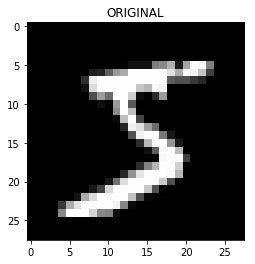

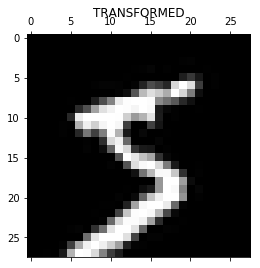

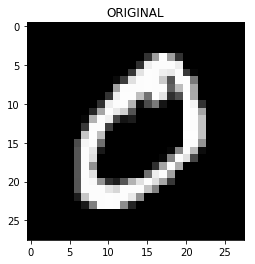

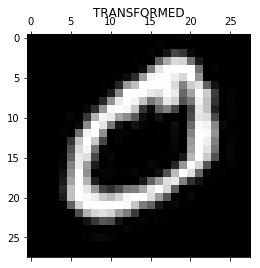

In [23]:
naug = 2
batch_xs = trainimg[:naug, :]
xs2 = augment_img(batch_xs)
for i in range(naug):
    x1 = batch_xs[i, :].reshape([28, 28])
    x2 = xs2[i, :].reshape([28, 28])
    
    plt.imshow(x1, cmap=plt.get_cmap('gray'))
    plt.title("ORIGINAL")
    plt.show()
    plt.matshow(x2,cmap=plt.cm.gray)
    plt.title("TRANSFORMED")
    plt.show()


### Run

In [11]:
# PARAMETERS
training_epochs = 100
batch_size      = 50
display_step    = 4
val_acc         = 0
val_acc_max     = 0
# OPTIMIZE
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # ITERATION
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # AUGMENT DATA
        batch_xs = augment_img(batch_xs)
        feeds = {x: batch_xs, y: batch_ys, is_training: True}
        sess.run(optm, feed_dict=feeds)
        avg_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = avg_cost / total_batch
    # DISPLAY
    if (epoch+1) % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        randidx = np.random.permutation(trainimg.shape[0])[:500]
        feeds = {x: trainimg[randidx], y: trainlabel[randidx], is_training: False}
        train_acc = sess.run(accr, feed_dict=feeds)
        print (" TRAIN ACCURACY: %.5f" % (train_acc))
        feeds = {x: valimg, y: vallabel, is_training: False}
        val_acc = sess.run(accr, feed_dict=feeds)
        print (" VALIDATION ACCURACY: %.5f" % (val_acc))
    # SAVE
    if (epoch+1) % save_step == 0:
        savename = savedir + "net-" + str(epoch) + ".ckpt"
        saver.save(sess=sess, save_path=savename)
        print (" [%s] SAVED." % (savename))
    # MAXIMUM VALIDATION ACCURACY
    if val_acc > val_acc_max:
        val_acc_max = val_acc
        best_epoch = epoch
        print ("\x1b[31m BEST EPOCH UPDATED!! [%d] \x1b[0m" % (best_epoch))
print ("OPTIMIZATION FINISHED")

AttributeError: module 'tensorflow._api.v1.keras.datasets.mnist' has no attribute 'train'

### Compute test accuracy

In [ ]:
best_epoch = 55
restorename = savedir + "net-" + str(best_epoch) + ".ckpt"
print ("LOADING [%s]" % (restorename))
saver.restore(sess, restorename)
feeds = {x: testimg, y: testlabel, is_training: False}
test_acc = sess.run(accr, feed_dict=feeds)
print ("TEST ACCURACY: %.5f" % (test_acc))